In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/road_anomalies
%rm -rf dataset
%mkdir dataset

!tar -xf dataset.tar -C dataset

/content/drive/MyDrive/road_anomalies


<h2 align="left"><font color=white>Preview Data</font></h2>

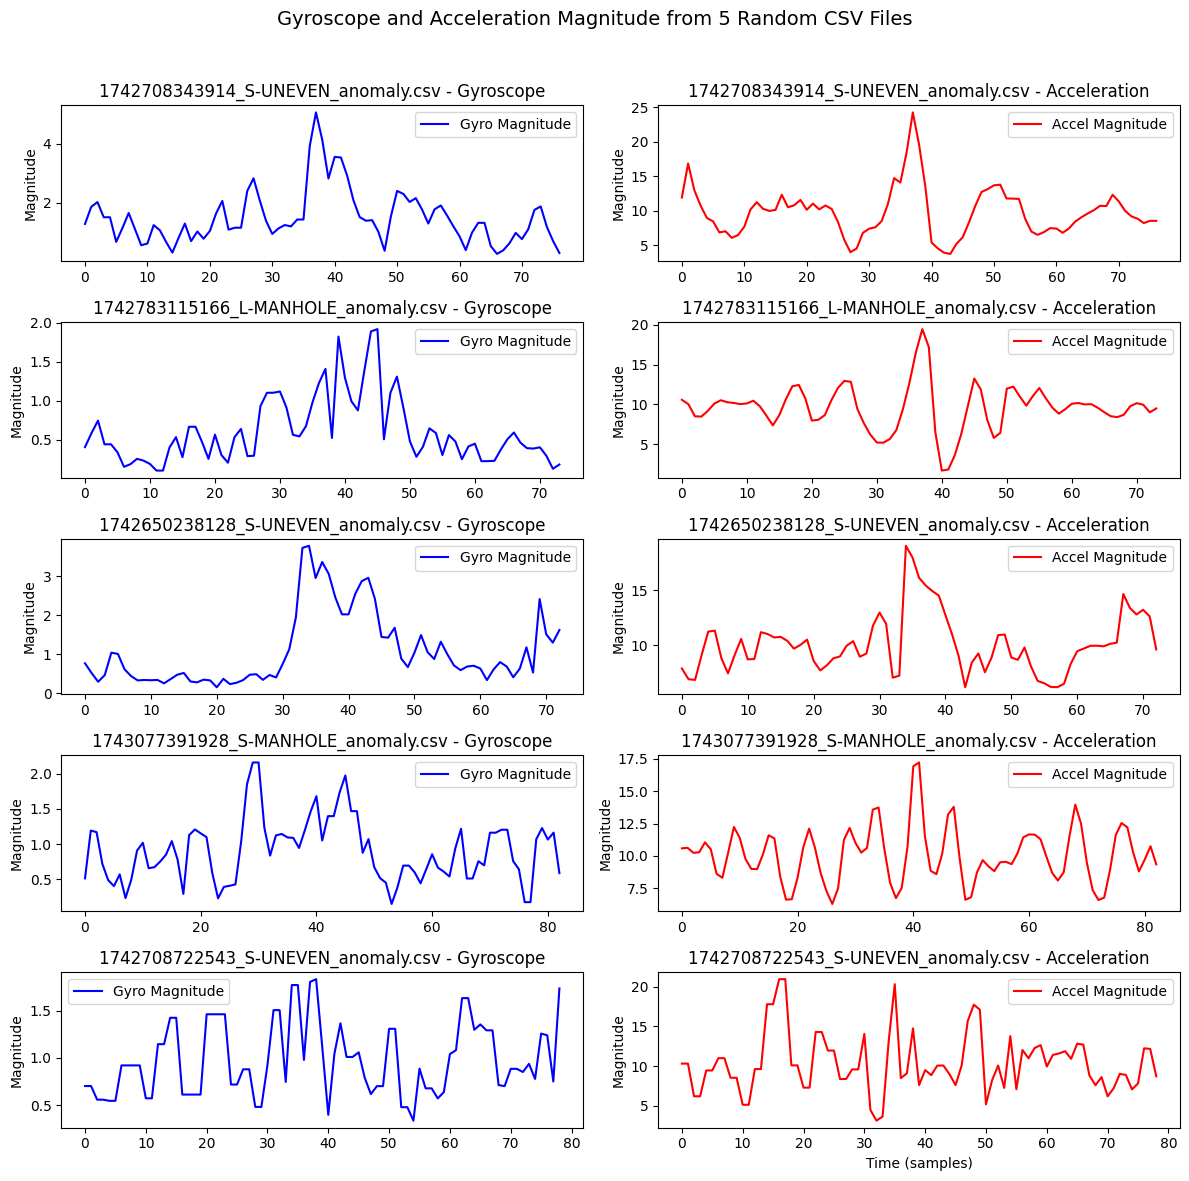

In [ ]:
import os
import random
import pandas as pd
import matplotlib.pyplot as plt

dataset_path = '/content/drive/MyDrive/road_anomalies/dataset'  # Adjust this path as needed
# Get list of all CSV files in the folder
csv_files = [f for f in os.listdir(dataset_path) if f.endswith(".csv")]

# Randomly select 5 CSV files
selected_files = random.sample(csv_files, 5)

def visualize_data(selected_files, dataset_path):
  # Plot setup
  fig, axes = plt.subplots(len(selected_files), 2, figsize=(12, 12))
  fig.suptitle("Gyroscope and Acceleration Magnitude from 5 Random CSV Files", fontsize=14)

  # Loop through selected files and plot
  for i, file in enumerate(selected_files):
    file_path = os.path.join(dataset_path, file)
    df = pd.read_csv(file_path)

    # Ensure columns exist
    if "gyroMag" not in df.columns or "accelMag" not in df.columns:
        print(f"Skipping {file} (missing required columns)")
        continue

    gyro_magnitude = df["gyroMag"].values
    accel_magnitude = df["accelMag"].values

    # Plot gyro
    axes[i, 0].plot(gyro_magnitude, label="Gyro Magnitude", color="blue")
    axes[i, 0].set_title(f"{file} - Gyroscope")
    axes[i, 0].set_ylabel("Magnitude")
    axes[i, 0].legend()

    # Plot acceleration
    axes[i, 1].plot(accel_magnitude, label="Accel Magnitude", color="red")
    axes[i, 1].set_title(f"{file} - Acceleration")
    axes[i, 1].set_ylabel("Magnitude")
    axes[i, 1].legend()

  # Adjust layout
  plt.xlabel("Time (samples)")
  plt.tight_layout(rect=[0, 0, 1, 0.96])
  plt.show()

visualize_data(selected_files, dataset_path)

In [ ]:
# Define anomaly categories
categories = ["S-MANHOLE", "L-MANHOLE", "S-BUMP", "L-BUMP", "S-UNEVEN", "L-UNEVEN"]
category_counts = {category: 0 for category in categories}

# 🔹 Count anomalies in all CSV files
for file in csv_files:
    for category in categories:
        if category in file.upper():  # Ensure case insensitivity
            category_counts[category] += 1
            break  # Stop after finding the first match

# 🔹 Print total anomaly counts
print("\nAnomaly Counts (from all CSV files):", len(csv_files))
for category, count in category_counts.items():
    print(f"{category}: {count}")



Anomaly Counts (from all CSV files): 1761
S-MANHOLE: 301
L-MANHOLE: 172
S-BUMP: 111
L-BUMP: 75
S-UNEVEN: 861
L-UNEVEN: 241


In [ ]:
# Initialize min-max variables
global_min_gyro, global_max_gyro = float('inf'), float('-inf')
global_min_accel, global_max_accel = float('inf'), float('-inf')

# First pass: Compute global min and max
for file in csv_files:
    df = pd.read_csv(os.path.join(dataset_path, file))

    # Update min-max values
    global_min_gyro = min(global_min_gyro, df['gyroMag'].min())
    global_max_gyro = max(global_max_gyro, df['gyroMag'].max())

    global_min_accel = min(global_min_accel, df['accelMag'].min())
    global_max_accel = max(global_max_accel, df['accelMag'].max())

print(f"Global Min-Max (Gyro): {global_min_gyro}, {global_max_gyro}")
print(f"Global Min-Max (Accel): {global_min_accel}, {global_max_accel}")

Global Min-Max (Gyro): 0.0, 11.54486094098134
Global Min-Max (Accel): 0.0389895144736597, 85.71550587045115


In [ ]:
from scipy.signal import butter, filtfilt
import numpy as np

def butter_highpass(cutoff, fs, order=4):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_lowpass(cutoff, fs, order=4):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def apply_filter(data, fs=50, highpass_cutoff=1, lowpass_cutoff=25):
    # High-pass filter
    b_high, a_high = butter_highpass(highpass_cutoff, fs)
    data_hp = filtfilt(b_high, a_high, data)

    # Low-pass filter
    b_low, a_low = butter_lowpass(lowpass_cutoff, fs)
    data_filtered = filtfilt(b_low, a_low, data_hp)

    return data_filtered

<h2 align="left"><font color=white>Preprocess Data</font></h2>

*   Interpolate Data
*   Normalize Data



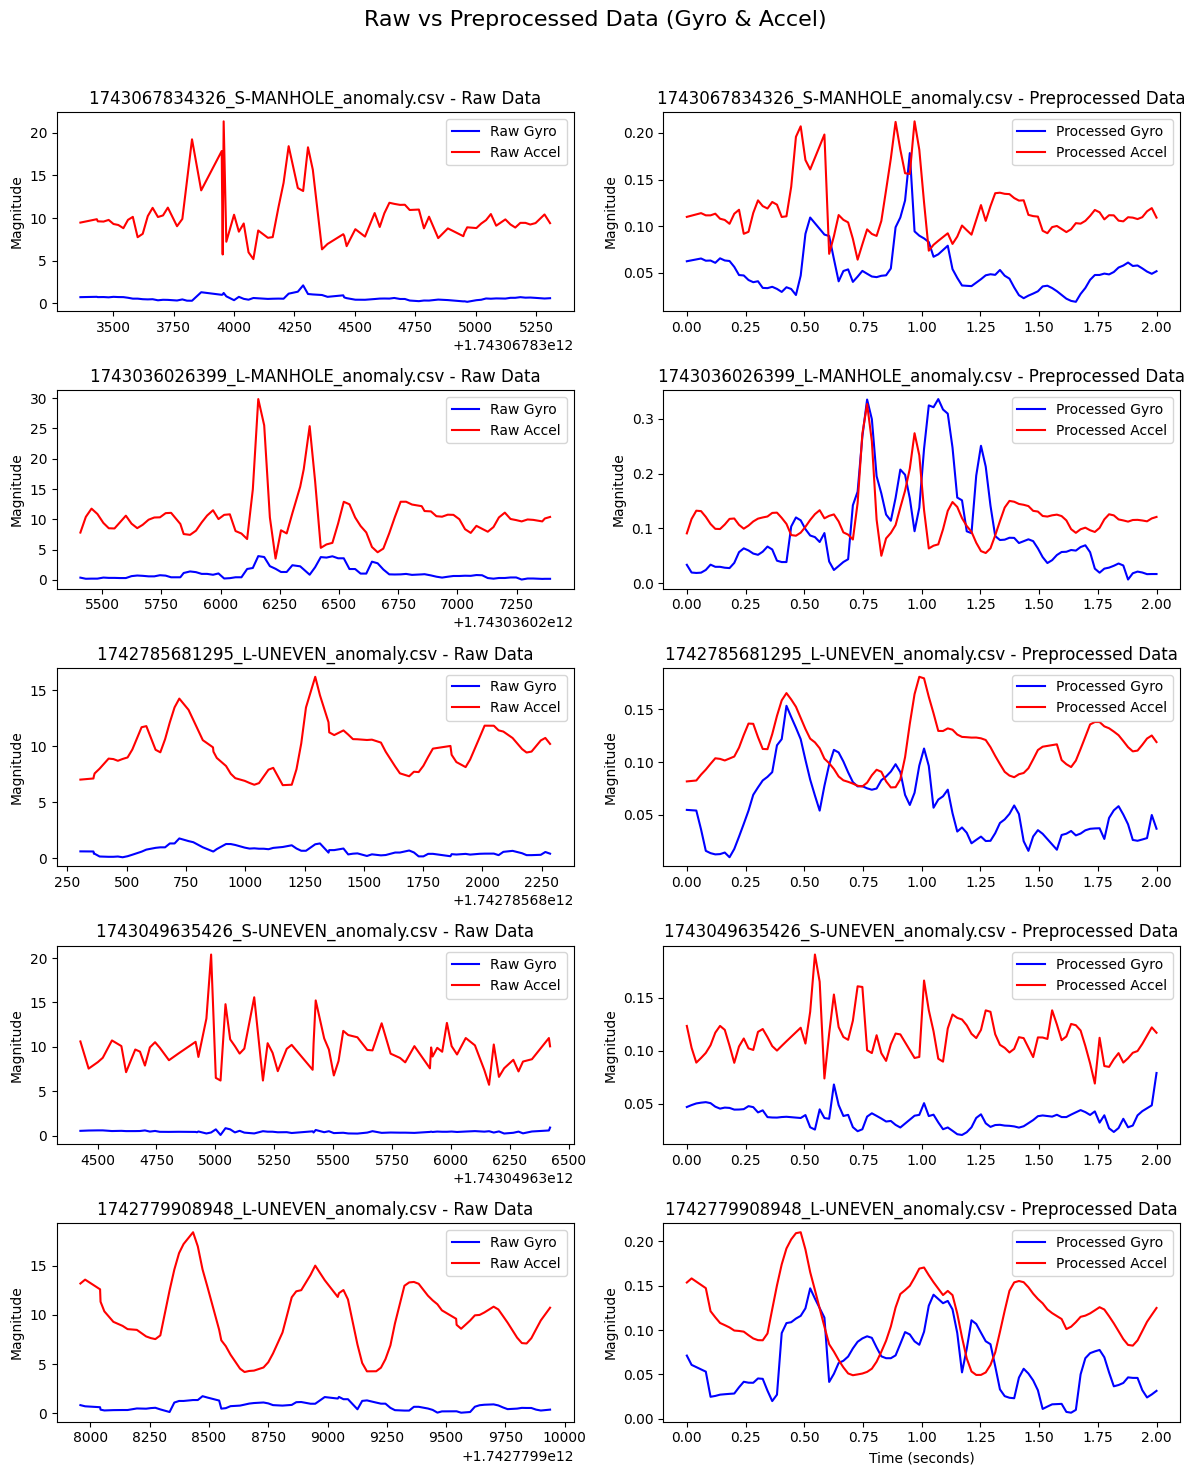

In [ ]:
import numpy as np
from scipy.interpolate import interp1d

def preprocess_csv(file_path, target_fs=50, duration=2.0, gap_threshold=30):
    # Load CSV (Assume columns: timestamp, gyro_mag, accel_mag)
    df = pd.read_csv(file_path)

    # Ensure required columns exist
    expected_cols = {'timestamp', 'gyroMag', 'accelMag'}
    if not expected_cols.issubset(df.columns):
        raise ValueError(f"CSV missing required columns: {expected_cols - set(df.columns)}")

    # Convert timestamps to relative time (start from 0)
    df['timestamp'] -= df['timestamp'].min()
    total_time = df['timestamp'].max()

    # Handle duplicate timestamps by averaging values
    df = df.groupby('timestamp', as_index=False).agg({'gyroMag': 'mean', 'accelMag': 'mean'})

    # Normalize timestamps to the desired duration
    if total_time > 0:
        df['timestamp'] *= (duration / total_time)

    # Define new evenly spaced timestamps (0 to duration, at target_fs Hz)
    new_time = np.linspace(0, duration, int(target_fs * duration))

    # Interpolation (Ensures uniform time steps)
    interp_gyro = interp1d(df['timestamp'], df['gyroMag'], kind='linear', fill_value='extrapolate')
    interp_accel = interp1d(df['timestamp'], df['accelMag'], kind='linear', fill_value='extrapolate')

    # Get resampled values
    new_gyro = interp_gyro(new_time)
    new_accel = interp_accel(new_time)

    # Compute Min-Max Scaling dynamically
    if global_max_gyro > global_min_gyro:
        new_gyro = (new_gyro - global_min_gyro) / (global_max_gyro - global_min_gyro)
    else:
        new_gyro = np.zeros_like(new_gyro)  # Avoid division by zero

    if global_max_accel > global_min_accel:
        new_accel = (new_accel - global_min_accel) / (global_max_accel - global_min_accel)
    else:
        new_accel = np.zeros_like(new_accel)

    return new_time, new_gyro, new_accel

def visualize_preprocessing(dataset_path, selected_files):
    fig, axes = plt.subplots(5, 2, figsize=(12, 15))
    fig.suptitle("Raw vs Preprocessed Data (Gyro & Accel)", fontsize=16)

    for i, file in enumerate(selected_files):
        file_path = os.path.join(dataset_path, file)
        df = pd.read_csv(file_path)

        # Check columns
        if "timestamp" not in df.columns or "gyroMag" not in df.columns or "accelMag" not in df.columns:
            print(f"Skipping {file} (missing required columns)")
            continue

        # Raw data
        axes[i, 0].plot(df['timestamp'], df['gyroMag'], color="blue", label="Raw Gyro")
        axes[i, 0].plot(df['timestamp'], df['accelMag'], color="red", label="Raw Accel")
        axes[i, 0].set_title(f"{file} - Raw Data")
        axes[i, 0].set_ylabel("Magnitude")
        axes[i, 0].legend()

        # Preprocessed data
        new_time, new_gyro, new_accel = preprocess_csv(file_path)
        axes[i, 1].plot(new_time, new_gyro, color="blue", label="Processed Gyro")
        axes[i, 1].plot(new_time, new_accel, color="red", label="Processed Accel")
        axes[i, 1].set_title(f"{file} - Preprocessed Data")
        axes[i, 1].set_ylabel("Magnitude")
        axes[i, 1].legend()

    plt.xlabel("Time (seconds)")
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Run visualization
visualize_preprocessing(dataset_path, selected_files)

<h2 align="left"><font color=white>Preview Spectrogram Image</font></h2>

In [ ]:
import scipy.signal
import cv2
from PIL import Image

def generate_spectrogram(signal, fs=50, WR=5, duration=2, overlap_percent=50):
    """Compute and return the spectrogram of a given signal."""
    # Compute total samples N based on sampling frequency and duration
    N = int(fs * duration)  # N = fs * 2 for your 2-second data

    # Compute window size based on WR and total samples N
    W_size = N // WR  # W_size = N / WR

    # Compute the overlap in samples
    noverlap = int(W_size * (overlap_percent / 100))

    # Use Hamming window explicitly (to match the paper)
    window = scipy.signal.get_window('hamming', W_size)
    # Compute spectrogram with Hamming window
    f, t, Sxx = scipy.signal.spectrogram(signal, fs=fs, window=window, nperseg=W_size, noverlap=noverlap)

    # Apply log transform to reduce dynamic range
    Sxx = np.log1p(Sxx)

    return f, t, Sxx

def plot_spectrogram(Sxx, title="Spectrogram"):
    """Plot the spectrogram."""
    spectrogram_img = generate_spectrogram_img(Sxx)
    plt.figure(figsize=(6, 6))
    plt.imshow(spectrogram_img)
    plt.axis("off")  # Hide axes for a cleaner display
    plt.title(title)
    plt.show()

def process_file_to_spectrogram(file_path):
    new_time, new_gyro, new_accel = preprocess_csv(file_path)

    # Generate spectrograms
    f_gyro, t_gyro, Sxx_gyro = generate_spectrogram(new_gyro)
    f_accel, t_accel, Sxx_accel = generate_spectrogram(new_accel)

    print(f"Sxx_gyro shape: {Sxx_gyro.shape}, Sxx_accel shape: {Sxx_accel.shape}")

    # Plot results
    plot_spectrogram(Sxx_gyro, title="Gyro Spectrogram")
    plot_spectrogram(Sxx_accel, title="Accel Spectrogram")

    return Sxx_gyro, Sxx_accel

def generate_spectrogram_img(Sxx):
    # Ensure input is a numpy array with float values
    Sxx = np.asarray(Sxx, dtype=np.float32)

    # Flip Sxx vertically to match Matplotlib orientation (low freq at bottom)
    Sxx = np.flipud(Sxx)

    # Normalize to [0,1]
    if Sxx.max() == Sxx.min():
        Sxx_normalized = np.zeros_like(Sxx)
    else:
        Sxx_normalized = (Sxx - Sxx.min()) / (Sxx.max() - Sxx.min())

    # Convert to uint8 (0-255 range)
    Sxx_uint8 = (Sxx_normalized * 255).astype(np.uint8)

    # Apply the VIRIDIS colormap for visualization
    spectrogram_img = cv2.applyColorMap(Sxx_uint8, cv2.COLORMAP_VIRIDIS)

    # Resize to 224x224 for MobileNet compatibility
    spectrogram_img = cv2.resize(spectrogram_img, (224, 224),
                                 interpolation=cv2.INTER_LANCZOS4)
    return spectrogram_img

def save_spectrogram(Sxx, save_path, file_name):
    """Generate a spectrogram image using OpenCV and save it as a file.

    Args:
        Sxx (numpy.ndarray): Spectrogram data (2D numpy array).
        file_path (str): Path to save the output image.
    """
    # Ensure save_path exists
    os.makedirs(save_path, exist_ok=True)

    spectrogram_img = generate_spectrogram_img(Sxx)

    file_path = os.path.join(save_path, f"{file_name}.jpg")
    # Save the image to the specified file path
    cv2.imwrite(file_path, spectrogram_img)

    return file_path

def process_and_save_spectrograms(file_path, save_folder):
    # Determine the subfolder based on the file name
    file_name = os.path.basename(file_path).replace(".csv", "")
    category = next((c for c in categories if c in file_name.upper()), "UNKNOWN")

    # Create the subfolder if it doesn't exist
    category_folder = os.path.join(save_folder, category)
    os.makedirs(category_folder, exist_ok=True)

    # Process the CSV and generate spectrograms
    new_time, new_gyro, new_accel = preprocess_csv(file_path)
    f_gyro, t_gyro, Sxx_gyro = generate_spectrogram(new_gyro)
    f_accel, t_accel, Sxx_accel = generate_spectrogram(new_accel)

    # Save spectrograms to the categorized subfolder
    save_spectrogram(Sxx_gyro, category_folder, file_name + "_gyro")
    save_spectrogram(Sxx_accel, category_folder, file_name + "_accel")

Processing 1743067834326_S-MANHOLE_anomaly.csv...
Sxx_gyro shape: (11, 9), Sxx_accel shape: (11, 9)


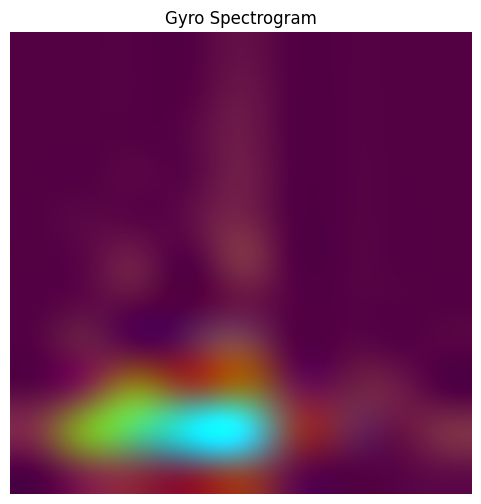

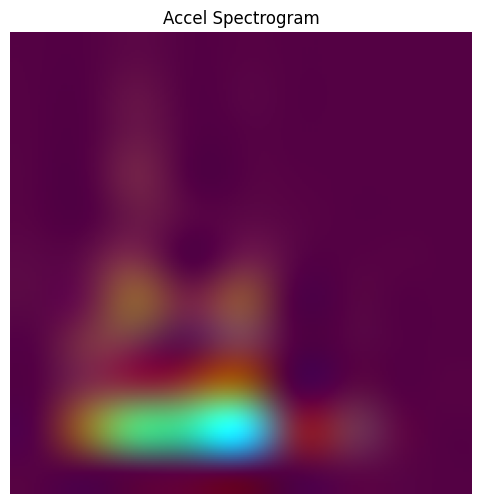

Processing 1743036026399_L-MANHOLE_anomaly.csv...
Sxx_gyro shape: (11, 9), Sxx_accel shape: (11, 9)


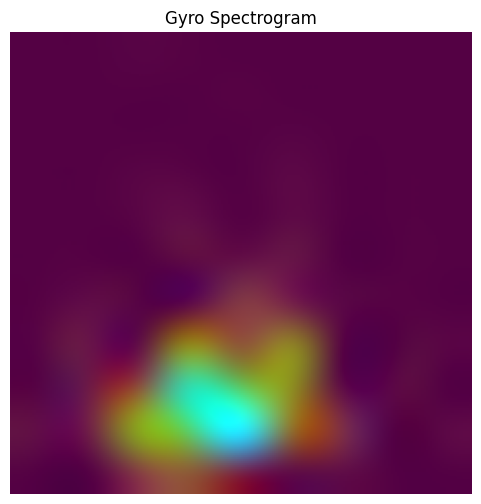

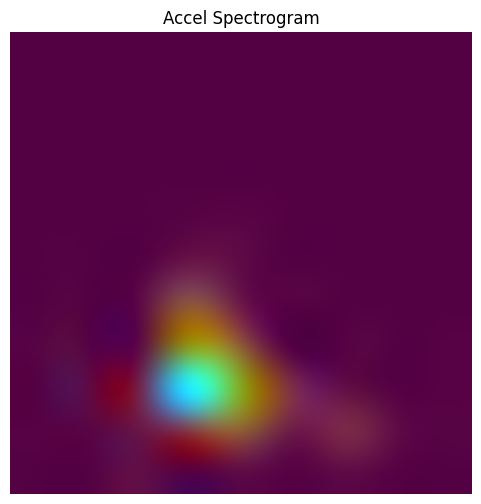

Processing 1742785681295_L-UNEVEN_anomaly.csv...
Sxx_gyro shape: (11, 9), Sxx_accel shape: (11, 9)


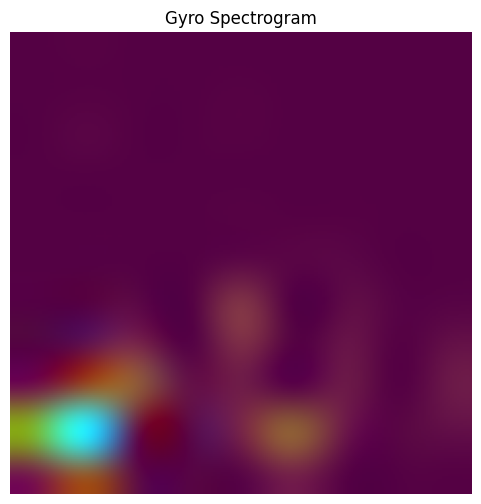

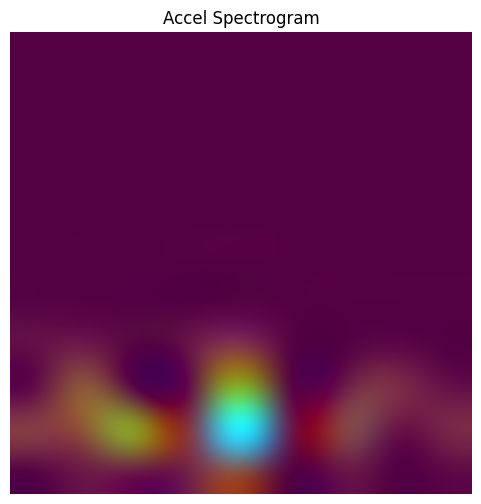

Processing 1743049635426_S-UNEVEN_anomaly.csv...
Sxx_gyro shape: (11, 9), Sxx_accel shape: (11, 9)


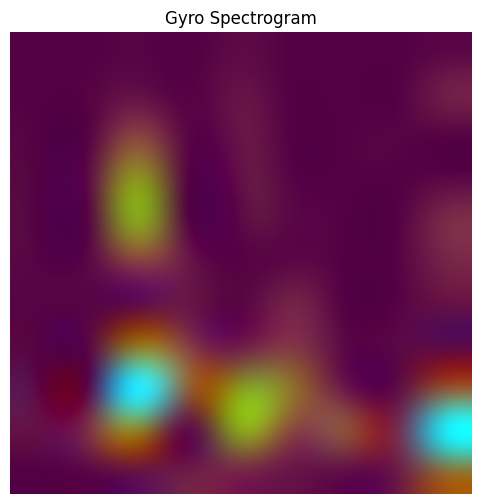

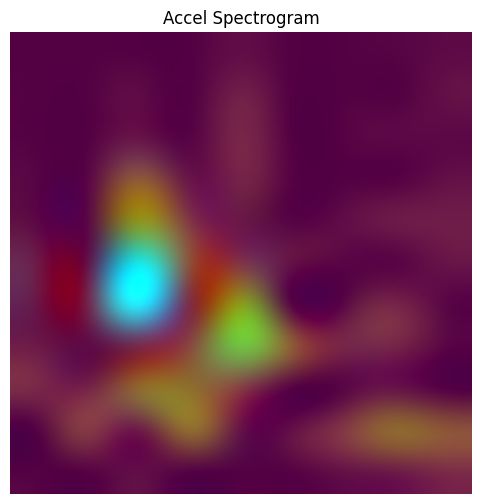

Processing 1742779908948_L-UNEVEN_anomaly.csv...
Sxx_gyro shape: (11, 9), Sxx_accel shape: (11, 9)


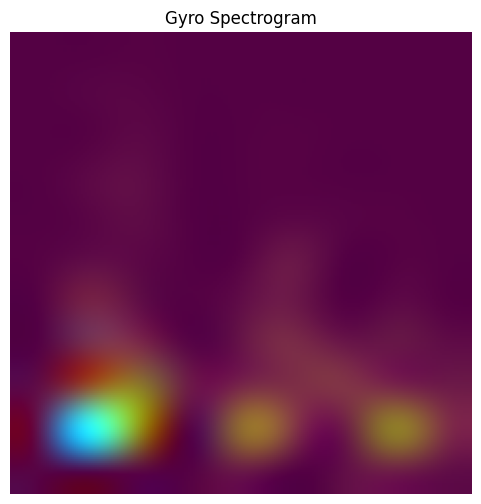

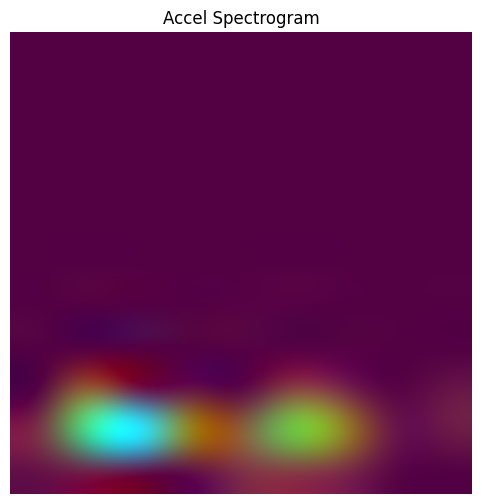

In [ ]:
for file in selected_files:
    file_path = os.path.join(dataset_path, file)
    print(f"Processing {file}...")
    process_file_to_spectrogram(file_path)

<h2 align="left"><font color=white>Generate Spectrogram Image for MobilenetV2 training</font></h2>

In [ ]:
%cd /content/drive/MyDrive/road_anomalies
%rm -rf spectrogram
%mkdir spectrogram

/content/drive/MyDrive/road_anomalies


In [ ]:
spectrogram_path = '/content/drive/MyDrive/road_anomalies/spectrogram'

In [ ]:
success_count = 0

for file in csv_files:
    file_path = os.path.join(dataset_path, file)
    try:
        process_and_save_spectrograms(file_path, spectrogram_path)
        success_count += 1
    except Exception as e:
        print(f"Error processing {file}: {e}")

print(f"Total Success: {success_count}")

Total Success: 1761


In [ ]:
def generate_spectrogram_data(spectrogram_path, categories):
    """Generate DataFrames for accelerometer and gyroscope spectrograms."""
    data_accel = []
    data_gyro = []

    for anomaly_type in categories:
        category_path = os.path.join(spectrogram_path, anomaly_type)

        if not os.path.exists(category_path):
            continue  # Skip if the folder does not exist

        for file in os.listdir(category_path):
            file_path = os.path.join(category_path, file)

            # Append to the correct list based on filename
            if "accel" in file.lower():
                data_accel.append((file_path, anomaly_type))
            elif "gyro" in file.lower():
                data_gyro.append((file_path, anomaly_type))

    # Convert to DataFrames
    df_accel = pd.DataFrame(data_accel, columns=['filepath', 'label'])
    df_gyro = pd.DataFrame(data_gyro, columns=['filepath', 'label'])

    return df_accel, df_gyro

# Create dataframe of acceleration and gyroscope
(df_accel, df_gyro) = generate_spectrogram_data(spectrogram_path, categories);
df_gyro.head()

filepath      label
0  /content/drive/MyDrive/road_anomalies/spectrog...  S-MANHOLE
1  /content/drive/MyDrive/road_anomalies/spectrog...  S-MANHOLE
2  /content/drive/MyDrive/road_anomalies/spectrog...  S-MANHOLE
3  /content/drive/MyDrive/road_anomalies/spectrog...  S-MANHOLE
4  /content/drive/MyDrive/road_anomalies/spectrog...  S-MANHOLE

<h2 align="left"><font color=white>Prepare Dataframe for MobilenetV2 training</font></h2>

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

# Split with stratification
train_df_accel, val_df_accel = train_test_split(df_accel, test_size=0.3, random_state=8, stratify=df_accel['label'])
train_df_gyro, val_df_gyro = train_test_split(df_gyro, test_size=0.3, random_state=8, stratify=df_gyro['label'])

# Print the number of images in each set
print(f"Number of images in the acceleration training set: {len(train_df_accel)}")
print(f"Number of images in the acceleration validation set: {len(val_df_accel)}")

print(f"Number of images in the gyro training set: {len(train_df_accel)}")
print(f"Number of images in the gyro validation set: {len(val_df_accel)}")

def verify_distribution(df, train_df, val_df):
  # 1. Class distribution in the entire dataset
  overall_distribution = df['label'].value_counts(normalize=True) * 100
  # 2. Class distribution in the training set
  train_distribution = train_df['label'].value_counts(normalize=True) * 100
  # 3. Class distribution in the validation set
  val_distribution = val_df['label'].value_counts(normalize=True) * 100
  print("Class distribution in the entire dataset:\n")
  print(overall_distribution.round(2))
  print('-'*40)
  print("\nClass distribution in the training set:\n")
  print(train_distribution.round(2))
  print('-'*40)
  print("\nClass distribution in the validation set:\n")
  print(val_distribution.round(2))

print("\nVerify distribution in the acceleration set:\n")
verify_distribution(df_accel, train_df_accel, val_df_accel)
print("\nVerify distribution in the gyroscope set:\n")
verify_distribution(df_gyro, train_df_gyro, val_df_gyro)

Number of images in the acceleration training set: 1232
Number of images in the acceleration validation set: 529
Number of images in the gyro training set: 1232
Number of images in the gyro validation set: 529

Verify distribution in the acceleration set:

Class distribution in the entire dataset:

label
S-UNEVEN     48.89
S-MANHOLE    17.09
L-UNEVEN     13.69
L-MANHOLE     9.77
S-BUMP        6.30
L-BUMP        4.26
Name: proportion, dtype: float64
----------------------------------------

Class distribution in the training set:

label
S-UNEVEN     48.86
S-MANHOLE    17.13
L-UNEVEN     13.72
L-MANHOLE     9.74
S-BUMP        6.33
L-BUMP        4.22
Name: proportion, dtype: float64
----------------------------------------

Class distribution in the validation set:

label
S-UNEVEN     48.96
S-MANHOLE    17.01
L-UNEVEN     13.61
L-MANHOLE     9.83
S-BUMP        6.24
L-BUMP        4.35
Name: proportion, dtype: float64

Verify distribution in the gyroscope set:

Class distribution in the ent

<h2 align="left"><font color=white>Building MobilnetV2 Model with Transfer Learning</font></h2>

In [ ]:
%pip install tensorflow==2.15

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.3/475.3 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 73.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 61.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 99.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 116.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 32.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 7.2 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.17.2
    Uninstalling wrapt-1.17.2:
      Successfully uninstalled wrapt-1.17.2
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.4
    Uninstalling protobuf-5.29.4:
      Successfully uni

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2  import preprocess_input

def data_argumentation_generation():
  # Slight Augmentation settings for training
  train_datagen = ImageDataGenerator(
    rescale=1./255,          # Essential
    zoom_range=0.1,          # Small zoom
    width_shift_range=0.05,  # Small width shift
    height_shift_range=0.05,  # Small height shift
    preprocessing_function=preprocess_input
  )

  # Only rescaling for validation
  val_datagen = ImageDataGenerator(rescale=1./255, preprocessing_function=preprocess_input)
  return train_datagen, val_datagen

train_datagen, val_datagen = data_argumentation_generation()

def data_generator(train_df, val_df):
  # Using flow_from_dataframe to generate batches
  # Generate training batches from the training dataframe
  train_generator = train_datagen.flow_from_dataframe(
      dataframe=train_df,                  # DataFrame containing training data
      x_col="filepath",                    # Column with paths to image files
      y_col="label",                       # Column with image labels
      target_size=(224, 224),              # Resize all images to size of 224x224
      batch_size=16,                       # Number of images per batch
      class_mode='categorical',            # One-hot encode labels
      seed=8,                             # Seed for random number generator to ensure reproducibility
      shuffle=False                        # Data is not shuffled; order retained from DataFrame
  )


  # Generate validation batches from the validation dataframe
  val_generator = val_datagen.flow_from_dataframe(
      dataframe=val_df,                    # DataFrame containing validation data
      x_col="filepath",                    # Column with paths to image files
      y_col="label",                       # Column with image labels
      target_size=(224, 224),              # Resize all images to size of 224x224
      batch_size=16,                       # Number of images per batch
      class_mode='categorical',            # One-hot encode labels
      seed=8,                             # Seed for random number generator to ensure reproducibility
      shuffle=False                        # Data is not shuffled; order retained from DataFrame
  )
  return (train_generator, val_generator)

(accel_train_generator, accel_val_generator) = data_generator(train_df_accel, val_df_accel)
(gyro_train_generator, gyro_val_generator) = data_generator(train_df_gyro, val_df_gyro)

print(f"Number of batches in accel_train_generator: {len(accel_train_generator)}")
print(f"Number of batches in accel_val_generator: {len(accel_val_generator)}\n")

print(f"Number of batches in gyro_train_generator: {len(gyro_train_generator)}")
print(f"Number of batches in gyro_val_generator: {len(gyro_val_generator)}\n")

Found 1232 validated image filenames belonging to 6 classes.
Found 529 validated image filenames belonging to 6 classes.
Found 1232 validated image filenames belonging to 6 classes.
Found 529 validated image filenames belonging to 6 classes.
Number of batches in accel_train_generator: 77
Number of batches in accel_val_generator: 34

Number of batches in gyro_train_generator: 77
Number of batches in gyro_val_generator: 34



In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

def compute_class_weights():
  class_labels = np.array(list(accel_train_generator.class_indices.keys()))
  print(accel_train_generator.class_indices)
  # Compute class weights
  weights = compute_class_weight(class_weight='balanced', classes=class_labels, y=train_df_accel['label'])
  print(weights)
  class_weights = dict(zip(accel_train_generator.class_indices.values(), weights))
  print(class_weights)
  return class_weights
class_weights = compute_class_weights()

{'L-BUMP': 0, 'L-MANHOLE': 1, 'L-UNEVEN': 2, 'S-BUMP': 3, 'S-MANHOLE': 4, 'S-UNEVEN': 5}
[3.94871795 1.71111111 1.21499014 2.63247863 0.97314376 0.34108527]
{0: 3.948717948717949, 1: 1.711111111111111, 2: 1.2149901380670611, 3: 2.6324786324786325, 4: 0.9731437598736177, 5: 0.34108527131782945}


9406464/9406464 [==============================] - 0s 0us/step


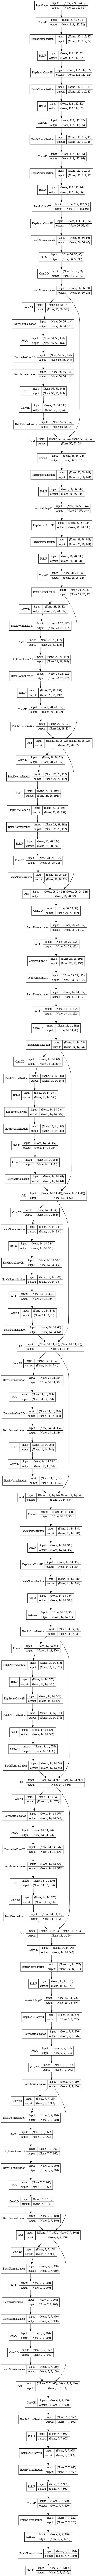

In [ ]:
from tensorflow.keras.applications import MobileNetV2 as PretrainedMobileNetV2
from keras.utils import plot_model

base_model = PretrainedMobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
plot_model(base_model, show_shapes=True, show_layer_names=False, dpi=80)

In [ ]:
from matplotlib.colors import LinearSegmentedColormap
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from keras.layers import DepthwiseConv2D, BatchNormalization, ReLU, Conv2D, Dropout, Add
from keras.layers import GlobalAveragePooling2D, Dense, Input, Activation
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.models import Model
from keras.utils import plot_model
from sklearn.metrics import classification_report, confusion_matrix

input_shape = (224, 224, 3)
num_classes = len(train_df_accel['label'].unique())

# Create the new model
def transfer_learning_mobilenet_v2(input_shape=(224, 224, 3), n_classes=1000, freeze_ratio=0.5):
    # Load the pre-trained MobileNet model without the top layers
    base_model = PretrainedMobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)

    # Determine how many layers to freeze
    total_layers = len(base_model.layers)
    freeze_layers = int(total_layers * freeze_ratio)
    # Freeze the first `freeze_layers` layers
    for layer in base_model.layers[:freeze_layers]:
        layer.trainable = False

    # Unfreeze the remaining layers
    for layer in base_model.layers[freeze_layers:]:
        layer.trainable = True

    # Add custom layers on top of the base model
    x = base_model.output
    x = GlobalAveragePooling2D()(x)  # Global Average Pooling
    x = Dropout(0.2)(x)
    x = Dense(256, activation='relu')(x)  # Fully connected layer
    output = Dense(n_classes, activation='softmax')(x)  # Output layer

    # Create the model
    model = Model(inputs=base_model.input, outputs=output)

    return model

mobilenet_v2_transfer_model = transfer_learning_mobilenet_v2(input_shape=(224, 224, 3), n_classes=num_classes)  # Adjust n_classes as needed

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
mobilenet_v2_transfer_model.compile(optimizer=optimizer,
                                    loss='categorical_crossentropy',
                                    metrics=['accuracy'])

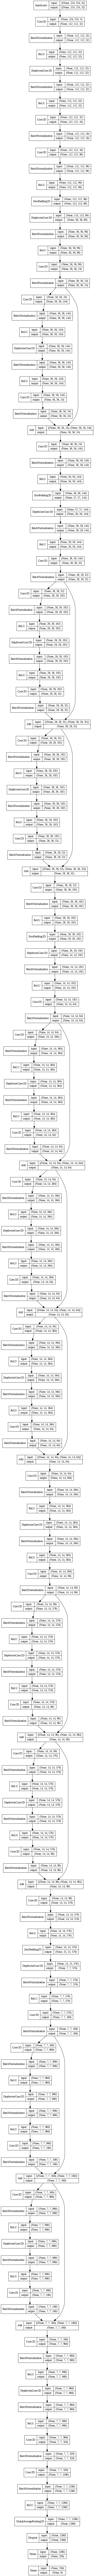

In [ ]:
plot_model(mobilenet_v2_transfer_model, show_shapes=True, show_layer_names=False, dpi=80)

In [ ]:
mobilenet_v2_transfer_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_3[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']      

<h2 align="left"><font color=white>Train Model with Acceleration Data</font></h2>

In [ ]:
# Define the callbacks
reduce_lr = ReduceLROnPlateau(monitor='accuracy', factor=0.5, patience=10, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='accuracy', mode='min', patience=10, restore_best_weights=True, verbose=1)
# Define the checkpoint file path
checkpoint_path = "/content/drive/MyDrive/road_anomalies/checkpoint/transfer_model_checkpoint.h5"
# Create a callback to save the model
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='accuracy',         # Monitor validation loss
    save_best_only=False,       # Save all checkpoints (set True to save the best one only)
    save_weights_only=False,    # Save the entire model
    verbose=1
)

# Total number of epochs+
num_epochs = 32

# Train the model
history = mobilenet_v2_transfer_model.fit(accel_train_generator,
                                      steps_per_epoch=len(accel_train_generator),
                                      epochs=num_epochs,
                                      validation_data=accel_val_generator,
                                      validation_steps=len(accel_val_generator),
                                      class_weight=class_weights,
                                      callbacks=[reduce_lr, early_stopping, checkpoint_callback])

Epoch 1/32
77/77 [==============================] - ETA: 0s - loss: 1.7758 - accuracy: 0.2029
Epoch 1: saving model to /content/drive/MyDrive/road_anomalies/checkpoint/transfer_model_checkpoint.h5
77/77 [==============================] - 93s 1s/step - loss: 1.7758 - accuracy: 0.2029 - val_loss: 1.6507 - val_accuracy: 0.1361 - lr: 5.0000e-05
Epoch 2/32
77/77 [==============================] - ETA: 0s - loss: 1.7660 - accuracy: 0.1761
Epoch 2: saving model to /content/drive/MyDrive/road_anomalies/checkpoint/transfer_model_checkpoint.h5
77/77 [==============================] - 92s 1s/step - loss: 1.7660 - accuracy: 0.1761 - val_loss: 1.6564 - val_accuracy: 0.1361 - lr: 5.0000e-05
Epoch 3/32
77/77 [==============================] - ETA: 0s - loss: 1.7599 - accuracy: 0.1818
Epoch 3: saving model to /content/drive/MyDrive/road_anomalies/checkpoint/transfer_model_checkpoint.h5
77/77 [==============================] - 94s 1s/step - loss: 1.7599 - accuracy: 0.1818 - val_loss: 1.6696 - val_accur

<h2 align="left"><font color=white>Evaluate Model with Acceleration Data</font></h2>

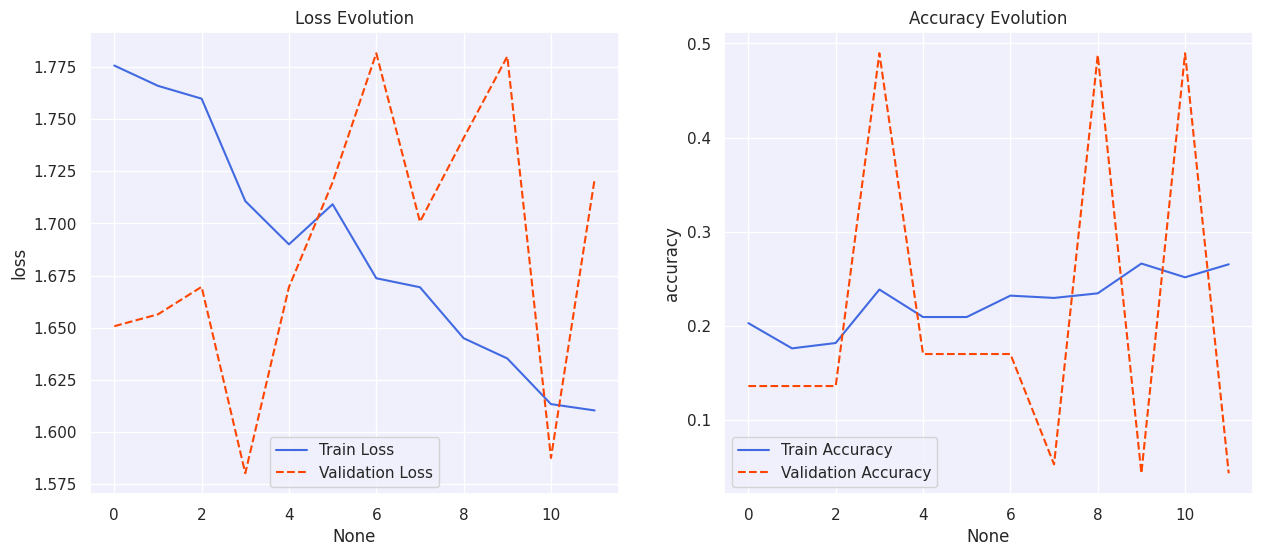

In [ ]:
import seaborn as sns

def plot_learning_curves(history, start_epoch=5):
    """
    Plot training and validation loss and accuracy curves.

    Parameters:
    - history: Training history (output from the model's fit method).
    - start_epoch: Epoch from which to start plotting. Default is 5 (i.e., plot from epoch 6 onwards).
    """

    # Convert the history.history dict to a pandas DataFrame
    df = pd.DataFrame(history.history)

    # Plot the curves from the specified epoch onwards
    df = df.iloc[start_epoch-1:]

    # Set the style of seaborn for better visualization
    sns.set(rc={'axes.facecolor': '#f0f0fc'}, style='darkgrid')

    # Plotting the learning curves
    plt.figure(figsize=(15,6))

    # Plotting the training and validation loss
    plt.subplot(1, 2, 1)
    sns.lineplot(x=df.index, y=df['loss'], color='royalblue', label='Train Loss')
    sns.lineplot(x=df.index, y=df['val_loss'], color='orangered', linestyle='--', label='Validation Loss')
    plt.title('Loss Evolution')

    # Plotting the training and validation accuracy
    plt.subplot(1, 2, 2)
    sns.lineplot(x=df.index, y=df['accuracy'], color='royalblue', label='Train Accuracy')
    sns.lineplot(x=df.index, y=df['val_accuracy'], color='orangered', linestyle='--', label='Validation Accuracy')
    plt.title('Accuracy Evolution')

    plt.show()

plot_learning_curves(history, start_epoch=1)

34/34 [==============================] - 16s 433ms/step
              precision    recall  f1-score   support

      L-BUMP       0.00      0.00      0.00        23
   L-MANHOLE       0.00      0.00      0.00        52
    L-UNEVEN       0.14      1.00      0.24        72
      S-BUMP       0.00      0.00      0.00        33
   S-MANHOLE       0.00      0.00      0.00        90
    S-UNEVEN       0.00      0.00      0.00       259

    accuracy                           0.14       529
   macro avg       0.02      0.17      0.04       529
weighted avg       0.02      0.14      0.03       529





/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


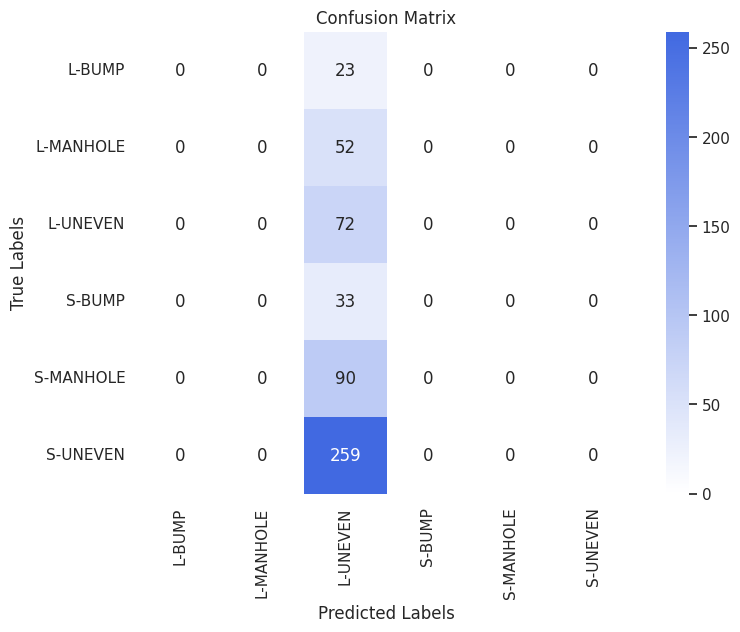

In [ ]:
def evaluate_model_performance(model, val_generator):
    """
    Evaluate the model's performance on the validation set and print the classification report.

    Parameters:
    - model: The trained model.
    - val_generator: Validation data generator.

    Returns:
    - report: Classification report as a string.
    """

    # Getting all the true labels for the validation set
    true_labels = val_generator.classes

    # Get the class labels (names) from the generator
    class_labels = list(val_generator.class_indices.keys())

    # To get the predicted labels, we predict using the model
    predictions = model.predict(val_generator, steps=len(val_generator))

    # Take the argmax to get the predicted class indices.
    predicted_labels = np.argmax(predictions, axis=1)

    # Extracting true labels from the validation generator
    true_labels = val_generator.classes

    # Classification report
    report = classification_report(true_labels, predicted_labels, target_names=class_labels)
    print(report)
    print('\n')

    # Define a custom colormap
    colors = ["white", "royalblue"]
    cmap_cm = LinearSegmentedColormap.from_list("cmap_cm", colors)

    # Confusion Matrix
    cm = confusion_matrix(true_labels, predicted_labels)

    # Plotting confusion matrix using seaborn
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, cmap=cmap_cm, fmt='d', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

evaluate_model_performance(mobilenet_v2_transfer_model, accel_val_generator)

<h2 align="left"><font color=white>Train Model with Gyroscope Data</font></h2>

In [ ]:
# Define the callbacks
reduce_lr = ReduceLROnPlateau(monitor='accuracy', factor=0.5, patience=10, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='accuracy', mode='min', patience=10, restore_best_weights=True, verbose=1)
# Define the checkpoint file path
checkpoint_path = "/content/drive/MyDrive/road_anomalies/checkpoint/transfer_model_gyro_checkpoint.h5"
# Create a callback to save the model
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='accuracy',         # Monitor validation loss
    save_best_only=False,       # Save all checkpoints (set True to save the best one only)
    save_weights_only=False,    # Save the entire model
    verbose=1
)

# Total number of epochs+
num_epochs = 32

# Train the model
gyro_model_history = mobilenet_v2_transfer_model.fit(gyro_train_generator,
                                      steps_per_epoch=len(gyro_train_generator),
                                      epochs=num_epochs,
                                      validation_data=gyro_val_generator,
                                      validation_steps=len(gyro_val_generator),
                                      class_weight=class_weights,
                                      callbacks=[reduce_lr, early_stopping, checkpoint_callback])

Epoch 1/32
77/77 [==============================] - ETA: 0s - loss: 1.8110 - accuracy: 0.1664
Epoch 1: saving model to /content/drive/MyDrive/road_anomalies/checkpoint/transfer_model_gyro_checkpoint.h5


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


77/77 [==============================] - 102s 1s/step - loss: 1.8110 - accuracy: 0.1664 - val_loss: 1.5905 - val_accuracy: 0.4896 - lr: 5.0000e-05
Epoch 2/32
77/77 [==============================] - ETA: 0s - loss: 1.7853 - accuracy: 0.1648
Epoch 2: saving model to /content/drive/MyDrive/road_anomalies/checkpoint/transfer_model_gyro_checkpoint.h5
77/77 [==============================] - 95s 1s/step - loss: 1.7853 - accuracy: 0.1648 - val_loss: 1.6239 - val_accuracy: 0.4896 - lr: 5.0000e-05
Epoch 3/32
77/77 [==============================] - ETA: 0s - loss: 1.7441 - accuracy: 0.2167
Epoch 3: saving model to /content/drive/MyDrive/road_anomalies/checkpoint/transfer_model_gyro_checkpoint.h5
77/77 [==============================] - 99s 1s/step - loss: 1.7441 - accuracy: 0.2167 - val_loss: 1.7223 - val_accuracy: 0.4896 - lr: 5.0000e-05
Epoch 4/32
77/77 [==============================] - ETA: 0s - loss: 1.7448 - accuracy: 0.2070
Epoch 4: saving model to /content/drive/MyDrive/road_anomalies/

<h2 align="left"><font color=white>Evaluate Model with Gyroscope Data</font></h2>

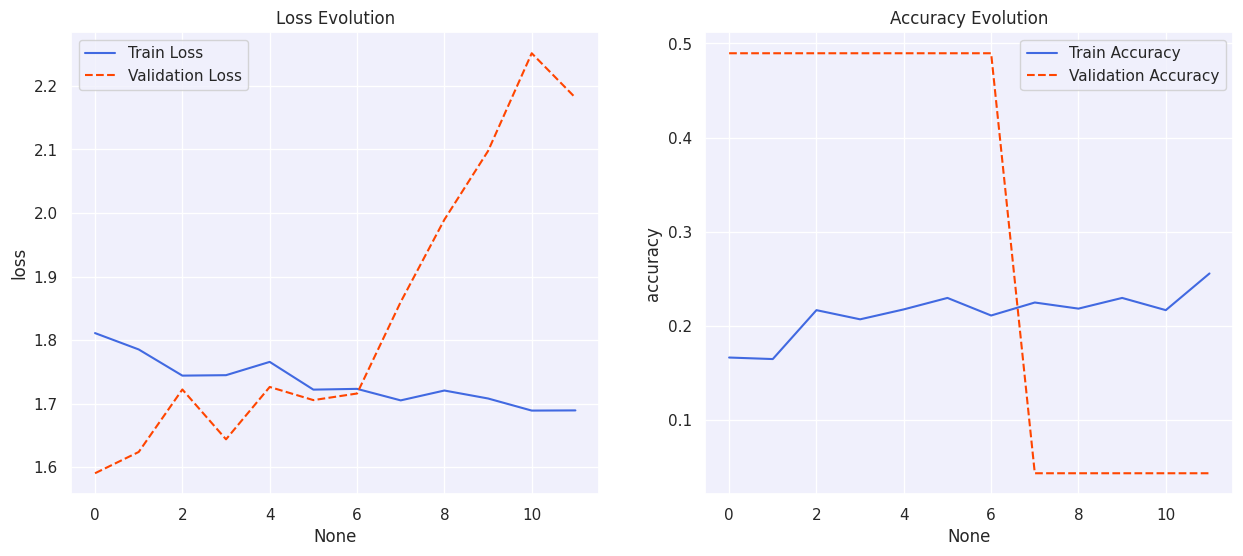

In [ ]:
plot_learning_curves(gyro_model_history, start_epoch=1)

34/34 [==============================] - 16s 457ms/step
              precision    recall  f1-score   support

      L-BUMP       0.00      0.00      0.00        23
   L-MANHOLE       0.00      0.00      0.00        52
    L-UNEVEN       0.00      0.00      0.00        72
      S-BUMP       0.00      0.00      0.00        33
   S-MANHOLE       0.00      0.00      0.00        90
    S-UNEVEN       0.49      1.00      0.66       259

    accuracy                           0.49       529
   macro avg       0.08      0.17      0.11       529
weighted avg       0.24      0.49      0.32       529





/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


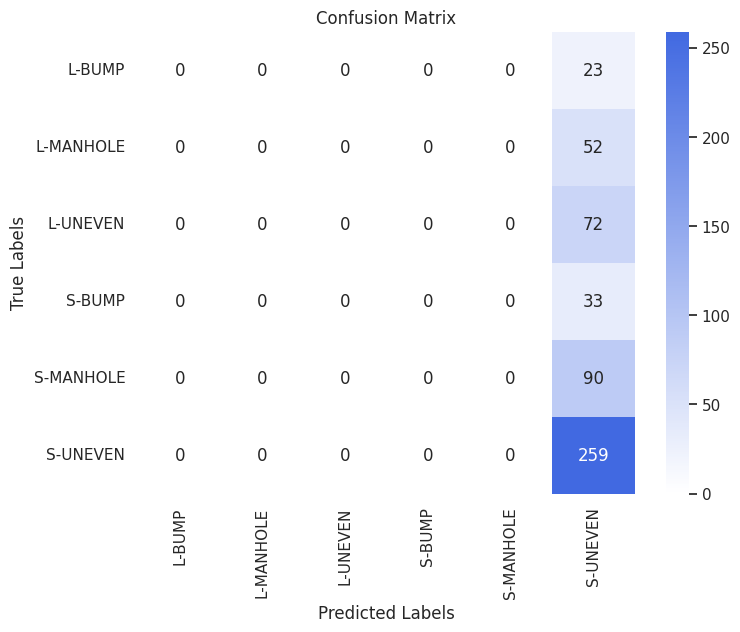

In [ ]:
evaluate_model_performance(mobilenet_v2_transfer_model, gyro_val_generator)

**Extract Features from Gyro & Accel Separately**

In [ ]:
import os
import re
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

def extract_label_from_filename(file_path):
    """Extract label from file name based on predefined categories."""
    file_name = os.path.basename(file_path)  # Convert to uppercase
    category = next((c for c in categories if c in file_name.upper()), "UNKNOWN")
    return category  # Default if no category is found

def preprocess_csv_knn(file_path, target_fs=50, duration=2.0):
    """Load and resample sensor data to a fixed frequency."""
    df = pd.read_csv(file_path)

    # Ensure required columns exist
    expected_cols = {'timestamp', 'gyroMag', 'accelMag'}
    if not expected_cols.issubset(df.columns):
        raise ValueError(f"CSV missing required columns: {expected_cols - set(df.columns)}")

    # Convert timestamps to relative time
    df['timestamp'] -= df['timestamp'].min()
    total_time = df['timestamp'].max()

    # Handle duplicate timestamps by averaging values
    df = df.groupby('timestamp', as_index=False).agg({'gyroMag': 'mean', 'accelMag': 'mean'})

    # Normalize timestamps to fit within `duration`
    if total_time > 0:
        df['timestamp'] *= (duration / total_time)

    # Define new evenly spaced timestamps (0 to duration, at target_fs Hz)
    new_time = np.linspace(0, duration, int(target_fs * duration))

    # Interpolation to resample data
    interp_gyro = interp1d(df['timestamp'], df['gyroMag'], kind='linear', fill_value='extrapolate')
    interp_accel = interp1d(df['timestamp'], df['accelMag'], kind='linear', fill_value='extrapolate')

    # Get resampled values
    new_gyro = interp_gyro(new_time)
    new_accel = interp_accel(new_time)

    return new_gyro, new_accel, new_time

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis
from scipy.signal import find_peaks
from scipy.fftpack import fft

def extract_xgboost_features(sensor_data):
    """ Extract statistical, frequency, and time-domain features """
   # Basic Stats
    basic_stats = np.array([
        np.mean(sensor_data),
        np.std(sensor_data),
        np.min(sensor_data),
        np.max(sensor_data),
        skew(sensor_data),
        kurtosis(sensor_data)
    ])

    # Frequency Features (FFT)
    fft_values = np.abs(fft(sensor_data))[:len(sensor_data) // 2]
    dom_freq = np.argmax(fft_values, axis=0)  # Most dominant frequency
    spectral_entropy = -np.sum((fft_values / np.sum(fft_values)) * np.log2(fft_values + 1e-6), axis=0)  # Avoid log(0)

    # Time-Domain Features (RMS & Peaks)
    rms = np.sqrt(np.mean(sensor_data ** 2))  # Energy level
    peaks, _ = find_peaks(sensor_data, height=np.mean(sensor_data) + np.std(sensor_data))  # Peak detection

    # Combine All Features
    features = np.concatenate([basic_stats, [dom_freq, spectral_entropy, rms, len(peaks)]])

    return features

In [ ]:
def extract_all_features(gyro_data, accel_data, timestamps):
    """ Extract features for gyro and accel separately and combine them """

    # Extract gyro features
    gyro_features = extract_xgboost_features(gyro_data)

    # Extract accel features
    accel_features = extract_xgboost_features(accel_data)

    # Compute time differences (for event duration)
    time_diffs = np.diff(timestamps)
    avg_time_gap = np.mean(time_diffs) if len(time_diffs) > 0 else 0

     # Cross-Signal Features
    corr = np.corrcoef(gyro_data, accel_data)[0, 1]  # Pearson correlation
    mean_diff = np.mean(np.abs(gyro_data - accel_data))  # Mean absolute difference
    energy_ratio = np.sqrt(np.mean(gyro_data ** 2)) / np.sqrt(np.mean(accel_data ** 2))  # Energy ratio

    # Merge Features
    combined_features = np.concatenate([gyro_features, accel_features, [avg_time_gap, corr, mean_diff, energy_ratio]])

    return combined_features

In [ ]:
def features_labels(csv_files):
    feature_matrix = []
    labels = []

    for file in csv_files:
        file_path = os.path.join(dataset_path, file)
        gyro, accel, timestamp = preprocess_csv_knn(file_path)
        features = extract_all_features(gyro, accel, timestamp)

        # 🏷 Extract label from filename
        label = extract_label_from_filename(file_path)

        if label != "UNKNOWN":  # Ignore unknown classes
            feature_matrix.append(features)
            labels.append(label)
    return feature_matrix, labels

feature_matrix, labels = features_labels(csv_files)

<h2 align="left"><font color=white>Compare Accuracy with KNN Time Domain</font></h2>

KNN Accuracy: 0.43

Classification Report:
              precision    recall  f1-score   support

      L-BUMP       0.29      0.36      0.32        25
   L-MANHOLE       0.30      0.51      0.38        47
    L-UNEVEN       0.19      0.23      0.21        75
      S-BUMP       0.50      0.25      0.33        36
   S-MANHOLE       0.30      0.19      0.23        90
    S-UNEVEN       0.59      0.59      0.59       256

    accuracy                           0.43       529
   macro avg       0.36      0.35      0.34       529
weighted avg       0.44      0.43      0.42       529



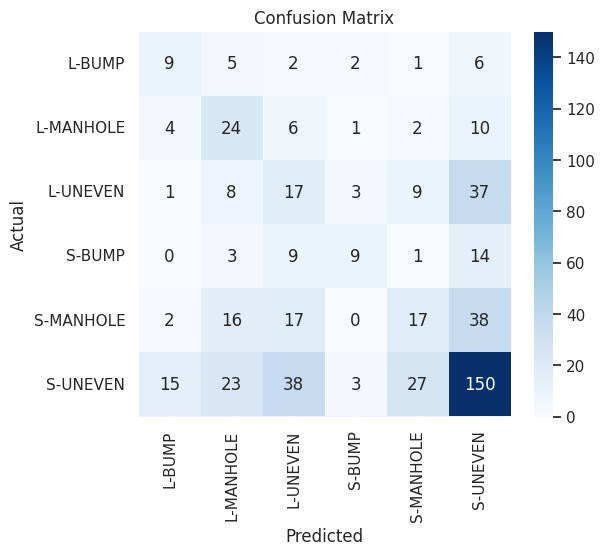

In [ ]:
def knn_train(feature_matrix, labels):
    # Convert to NumPy array
    X = np.array(feature_matrix)
    y = np.array(labels)

    # Normalize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Convert labels to numerical values
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    # Train-Test Split
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.3, random_state=8)

    # Train KNN Classifier
    knn = KNeighborsClassifier(n_neighbors=3, metric='euclidean')
    knn.fit(X_train, y_train)

    # Predict & Evaluate
    y_pred = knn.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"KNN Accuracy: {accuracy:.2f}")

    # 🟢 Precision, Recall, F1-Score
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

    # 🟢 Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

knn_train(feature_matrix, labels)

<h2 align="left"><font color=white>Compare Accuracy with XGBoost on Multi-label classification</font></h2>

XGBoost Accuracy: 0.53

Classification Report:
              precision    recall  f1-score   support

      L-BUMP       0.58      0.28      0.38        25
   L-MANHOLE       0.35      0.40      0.38        47
    L-UNEVEN       0.42      0.13      0.20        75
      S-BUMP       0.46      0.17      0.24        36
   S-MANHOLE       0.41      0.21      0.28        90
    S-UNEVEN       0.57      0.85      0.69       256

    accuracy                           0.53       529
   macro avg       0.47      0.34      0.36       529
weighted avg       0.50      0.53      0.48       529



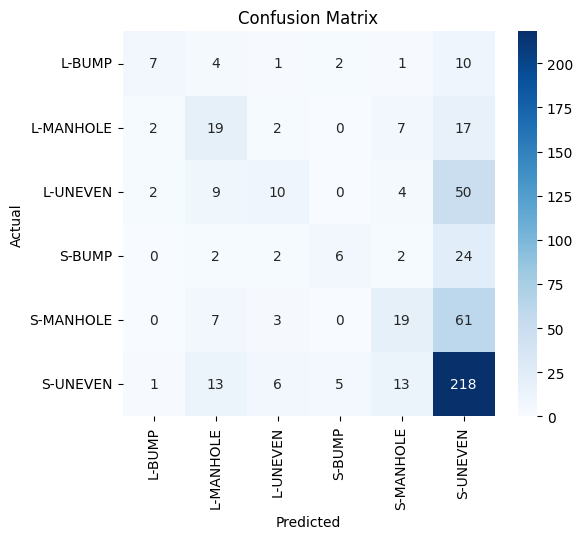

In [ ]:
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import StandardScaler

def xgb_train(feature_matrix, labels):
    X_features  = np.array(feature_matrix)
    scaler = StandardScaler()
    X_features = scaler.fit_transform(X_features)  # Normalize features
    y_labels  = np.array(labels)

    # Convert labels to numerical values
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y_labels)

    # Train-Test Split (30% for testing)
    X_train, X_test, y_train, y_test = train_test_split(X_features, y_encoded, test_size=0.3, random_state=8)

    # Train XGBoost Classifier
    xgb_model = xgb.XGBClassifier(
        objective='multi:softmax',
        num_class=len(np.unique(y_encoded)),
        n_estimators=100,
        learning_rate=0.1,
        max_depth=3,
        random_state=8,
        eval_metric='mlogloss'
    )
    xgb_model.fit(X_train, y_train)

    # Predict & Evaluate
    y_pred = xgb_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"XGBoost Accuracy: {accuracy:.2f}")

    # Precision, Recall, F1-Score
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

    # Confusion Matrix Visualization
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

xgb_train(feature_matrix, labels)

<h2 align="left"><font color=white>Compare Accuracy with SVM on Multi-label classification</font></h2>

SVM Accuracy: 0.51

Classification Report:
              precision    recall  f1-score   support

      L-BUMP       0.80      0.32      0.46        25
   L-MANHOLE       0.30      0.32      0.31        47
    L-UNEVEN       0.38      0.04      0.07        75
      S-BUMP       0.60      0.17      0.26        36
   S-MANHOLE       0.00      0.00      0.00        90
    S-UNEVEN       0.54      0.93      0.68       256

    accuracy                           0.51       529
   macro avg       0.44      0.30      0.30       529
weighted avg       0.42      0.51      0.41       529



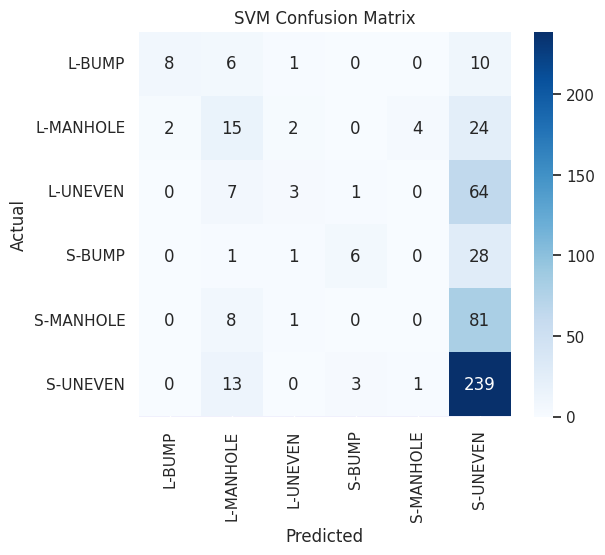

In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

def svm_train(feature_matrix, labels):
    X_features = np.array(feature_matrix)
    y_labels = np.array(labels)

    # Convert labels to numerical values
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y_labels)

    # Normalize features (SVM is sensitive to feature scaling)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_features)

    # Train-Test Split (30% for testing)
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.3, random_state=8)

    # Train SVM Classifier
    svm_model = SVC(kernel='rbf', C=2.0, gamma='scale', probability=True, random_state=8)
    svm_model.fit(X_train, y_train)

    # Predict & Evaluate
    y_pred = svm_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"SVM Accuracy: {accuracy:.2f}")

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("SVM Confusion Matrix")
    plt.show()

# Run SVM Training
svm_train(feature_matrix, labels)

In [ ]:
# Define anomaly categories
binary_categories = ["S-", "L-"]
binary_category_counts = {category: 0 for category in binary_categories}

# 🔹 Count anomalies in all CSV files
for file in csv_files:
    for category in binary_categories:
        if category in file.upper():  # Ensure case insensitivity
            binary_category_counts[category] += 1
            break  # Stop after finding the first match

# 🔹 Print total anomaly counts
print("\nAnomaly Counts (from all CSV files):", len(csv_files))
for category, count in binary_category_counts.items():
    print(f"{category}: {count}")

def extract_binary_label_from_filename(file_path):
    """Extract label from file name based on predefined categories."""
    file_name = os.path.basename(file_path)  # Convert to uppercase
    category = next((c for c in binary_categories if c in file_name.upper()), "UNKNOWN")
    return category  # Default if no category is found

def features_labels_for_binary_classification(csv_files):
    feature_matrix = []
    labels = []

    for file in csv_files:
        file_path = os.path.join(dataset_path, file)
        gyro, accel, timestamp = preprocess_csv_knn(file_path)
        features = extract_all_features(gyro, accel, timestamp)

        # 🏷 Extract label from filename
        label = extract_binary_label_from_filename(file_path)

        if label != "UNKNOWN":  # Ignore unknown classes
            feature_matrix.append(features)
            labels.append(label)
    return feature_matrix, labels

binary_feature_matrix, binary_labels = features_labels_for_binary_classification(csv_files)


Anomaly Counts (from all CSV files): 1761
S-: 1273
L-: 488


<h2 align="left"><font color=white>Compare Accuracy with KNN on Binary Classification</font></h2>

KNN Accuracy: 0.71

Classification Report:
              precision    recall  f1-score   support

          L-       0.47      0.35      0.40       147
          S-       0.77      0.85      0.81       382

    accuracy                           0.71       529
   macro avg       0.62      0.60      0.61       529
weighted avg       0.69      0.71      0.70       529



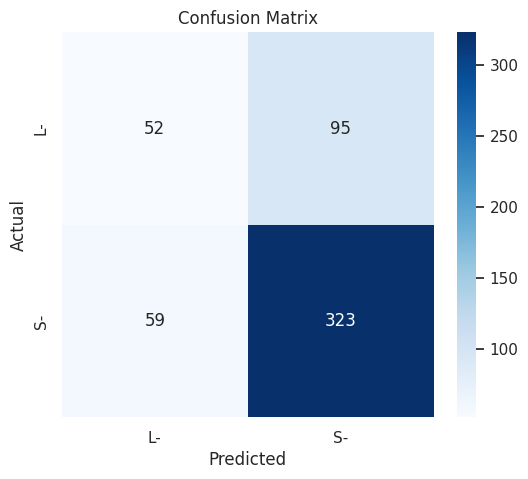

In [ ]:
knn_train(binary_feature_matrix, binary_labels)

<h2 align="left"><font color=white>Compare Accuracy with XGBoost on Binary Classification</font></h2>

XGBoost Accuracy: 0.75

Classification Report:
              precision    recall  f1-score   support

          L-       0.58      0.31      0.41       147
          S-       0.78      0.91      0.84       382

    accuracy                           0.75       529
   macro avg       0.68      0.61      0.62       529
weighted avg       0.72      0.75      0.72       529



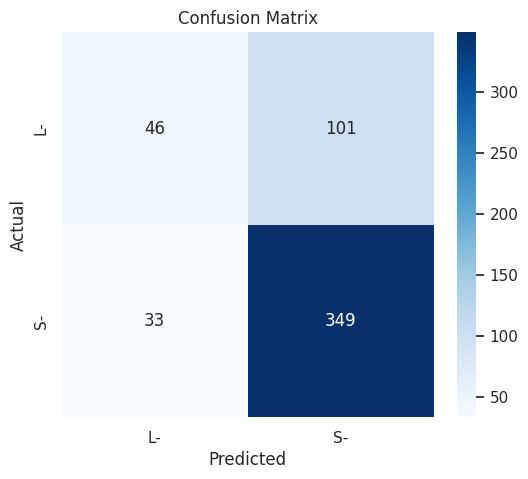

In [ ]:
xgb_train(binary_feature_matrix, binary_labels)

<h2 align="left"><font color=white>Compare Accuracy with SVM on Binary Classification</font></h2>

SVM Accuracy: 0.76

Classification Report:
              precision    recall  f1-score   support

          L-       0.65      0.27      0.38       147
          S-       0.77      0.94      0.85       382

    accuracy                           0.76       529
   macro avg       0.71      0.61      0.62       529
weighted avg       0.74      0.76      0.72       529



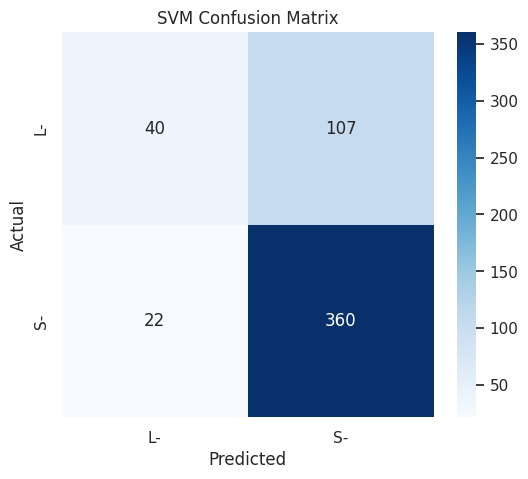

In [ ]:
svm_train(binary_feature_matrix, binary_labels)